Proposal for Group 42

Let's upload our possible datasets in the data folder so we can easily have a look at them and possibly run some functions on them if we need. 

In [1]:
library(tidyverse)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [35]:
#reads in data as well as turns relevant double columns into factors 

url<- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"


heart_data <- read_csv(url)%>%
    mutate(sex = as_factor(sex))%>%
    mutate(smoking = as_factor(smoking))%>%
    mutate(DEATH_EVENT = as_factor(DEATH_EVENT))%>%
    mutate(high_blood_pressure = as_factor(high_blood_pressure))%>%
    mutate(diabetes = as_factor(diabetes))%>%
    mutate(anaemia= as_factor(anaemia))


#creates factor levels for columns that make sense with column name 
levels(heart_data$sex)<- c("female","male")
levels(heart_data$smoking)<- c("no","yes")
levels(heart_data$DEATH_EVENT)<- c("no","yes")
levels(heart_data$high_blood_pressure)<- c("no","yes")
levels(heart_data$diabetes)<- c("no","yes")
levels(heart_data$anaemia)<- c("no","yes")


#normalize platelets column so that all values are a fraction of the max value 
max_plat<- max(heart_data$platelets)
heart_data_platelets_norm <- heart_data%>%
    mutate(platelets_norm = platelets/max_plat)%>%
    select(-platelets)%>%
    relocate(platelets_norm, .before = serum_creatinine)

 




Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



Possible Predictive Questions
-Does a patient have high blood pressure if they smoke and have diabetes?
-Will a patient experience a death event if they smoke, have high blood pressure and are over 70?
-If a patient smokes and has low platelet(less than 25% of max platelet in study) count will they have anaemia?

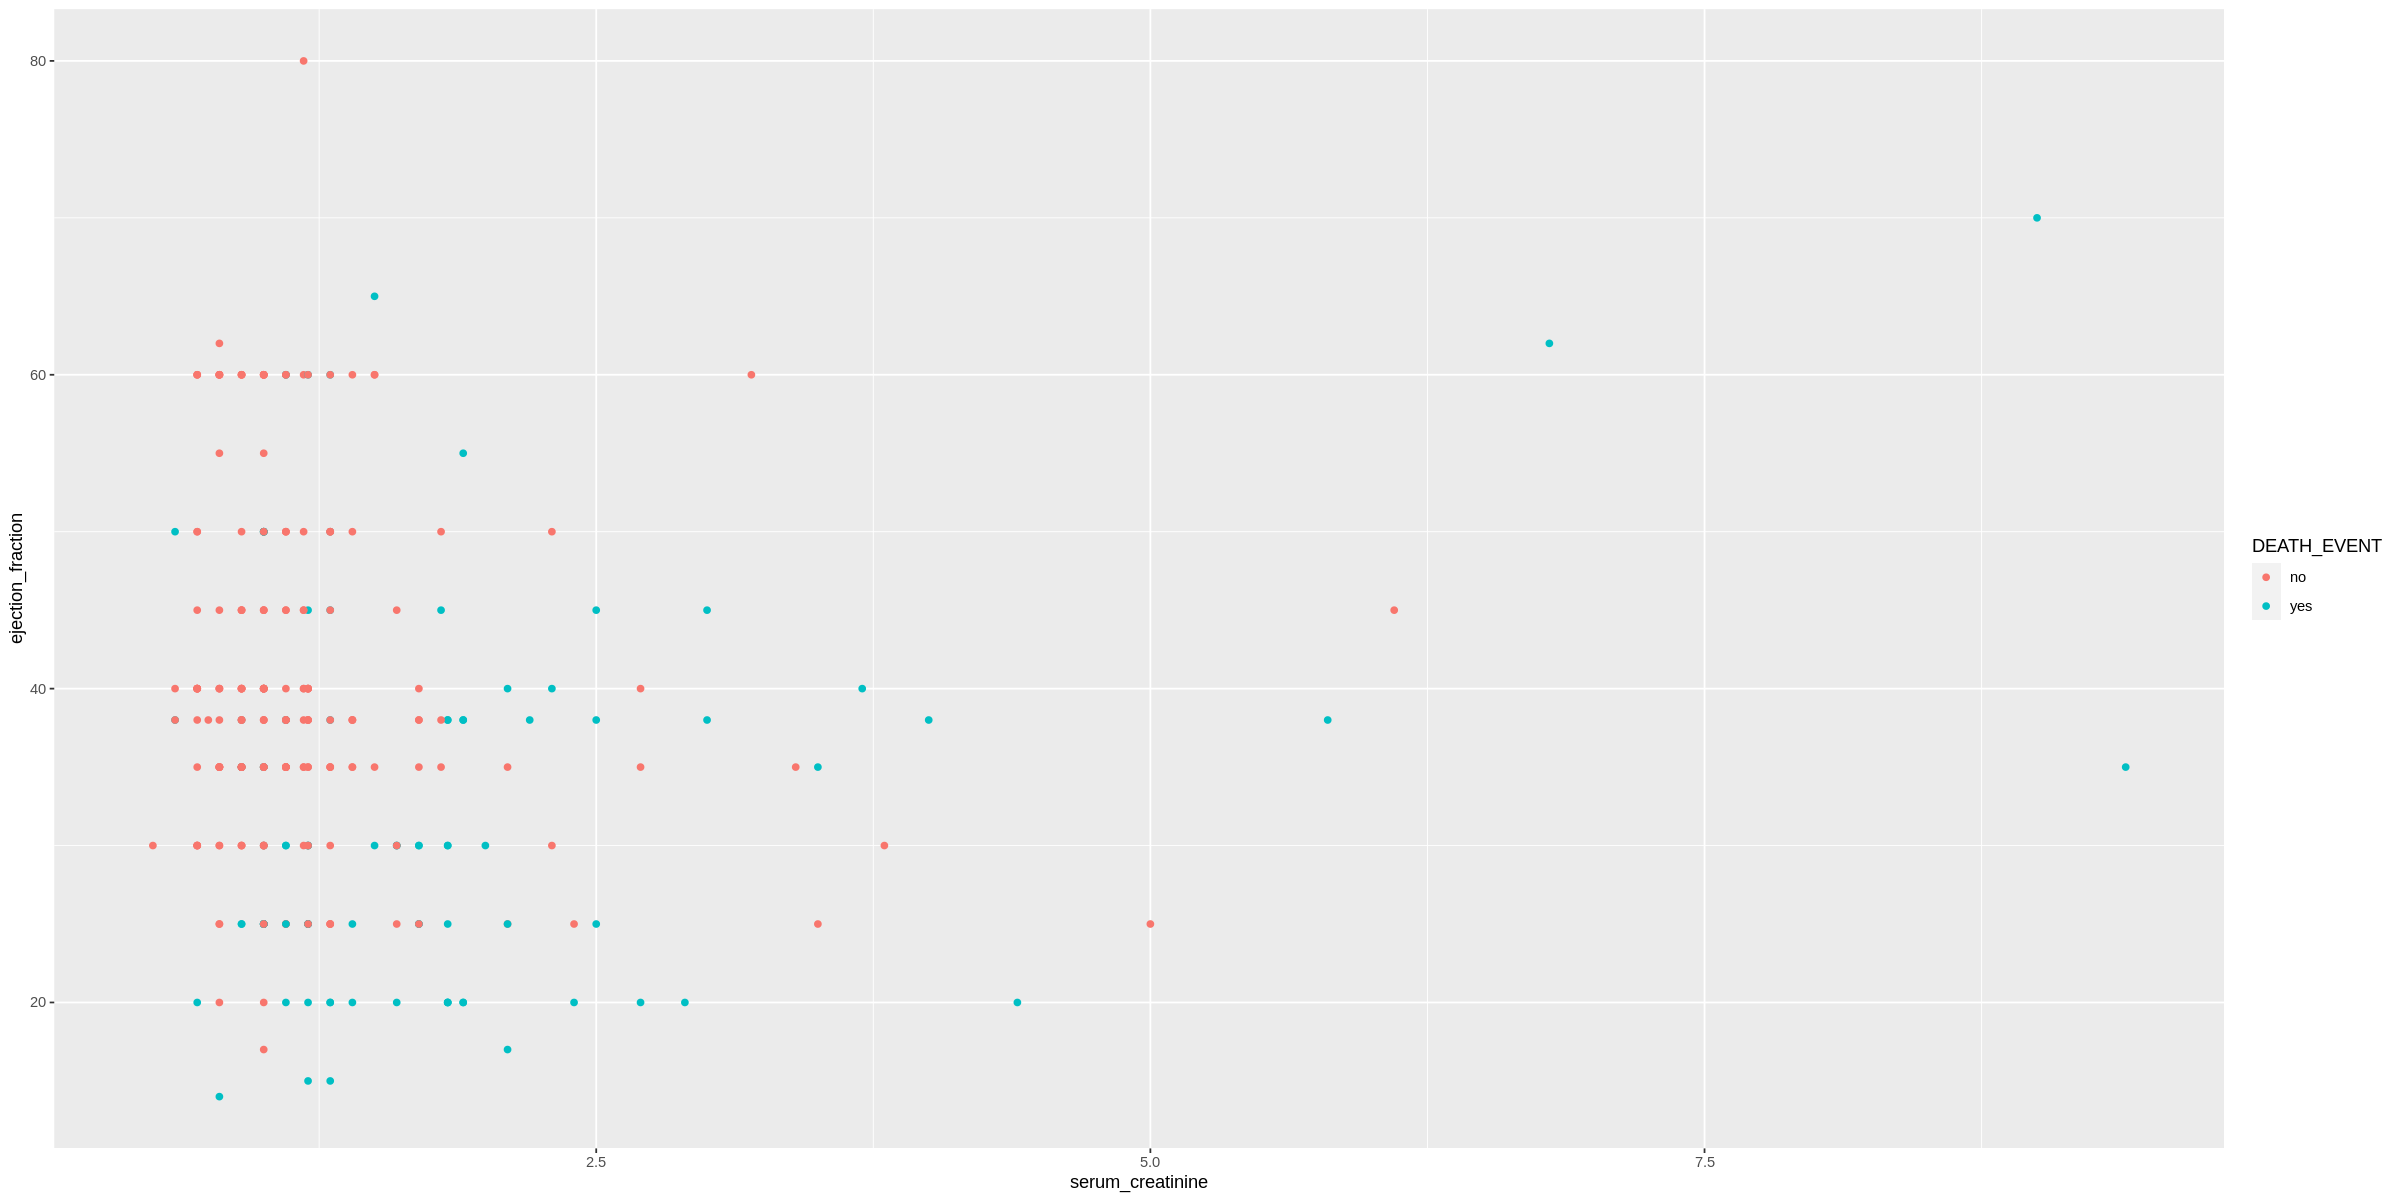

In [34]:
#example question if we were to look at how serum creatinine and ejection fraction can be used as predictors of a death event

serum_data <- heart_data%>%
    select(DEATH_EVENT, serum_creatinine, ejection_fraction)%>%
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT))+
    geom_point()
    

serum_data